In [1]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
import os
os.environ['VXM_BACKEND'] = 'pytorch'
from voxelmorph import networks
import voxelmorph as vxm
from tqdm.notebook import trange


In [2]:
data = dict(np.load('mnist.npz'))

In [3]:
x_train_all = data['x_train'].astype('float')/255
x_test_all = data['x_test'].astype('float')/255

x_train_all = np.pad(x_train_all, ((0, 0), (2, 2), (2, 2)), 'constant')[..., np.newaxis]
x_test_all = np.pad(x_test_all, ((0, 0), (2, 2), (2, 2)), 'constant')[..., np.newaxis]

vol_shape = list(x_train_all.shape[1:-1])

In [4]:
# extract all 3s
digit = 3

x_train = x_train_all[data['y_train'] == digit, ...]
y_train = data['y_train'][data['y_train'] == digit]
x_test = x_test_all[data['y_test'] == digit, ...].astype('float')/255
y_test = data['y_test'][data['y_test'] == digit]

In [5]:
# from torchvision.io import read_image
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    def __init__(self, img_labels,img_data, transform=None, target_transform=None):
        self.img_data = img_data.astype(np.float32)
        self.img_labels = img_labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        
        label = self.img_labels[idx]
        image = self.img_data[idx].transpose(-1,0,1)
        if self.transform:
            image = self.transform(image[idx])
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [6]:
dataset = MNISTDataset(y_train, x_train,)

In [7]:
batch_size = 8

In [8]:
from torch.utils.data import DataLoader
device = torch.device('cuda:1')
train_dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [9]:
train_features,_ = next(iter(train_dataloader))

In [10]:
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

In [11]:
altas = torch.mean((torch.from_numpy(dataset.img_data)),dim=0).squeeze().unsqueeze(0)

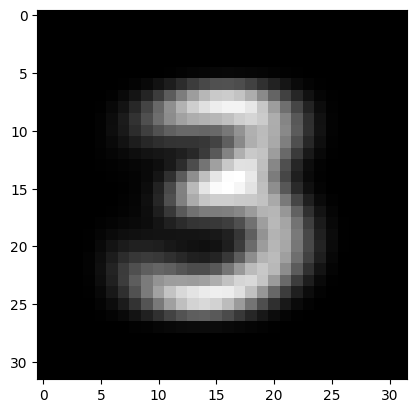

In [12]:
plt.imshow(altas.squeeze(),cmap='gray')

In [13]:
# altas = torch.mean(train_features,0)

In [14]:
model = torch.compile(networks.TemplateCreation((32,32),altas,nb_unet_features=[enc_nf, dec_nf])).to(device)

In [15]:
image_loss_func = nn.MSELoss()
neg_loss_func = lambda y_pred,_: image_loss_func(y_pred, model.atlas)
losses = [image_loss_func, neg_loss_func, nn.MSELoss(), vxm.losses.Grad('l2', loss_mult=2).loss]
loss_weights = [0.5, 0.5, 0.1, 0.01]

In [16]:
shape = (32,32)
zeros = torch.zeros((1, len(shape), *shape))

In [17]:
optimizer=torch.optim.Adam(model.parameters(), lr=0.001,eps=1e-07)


In [18]:
loss_his = []
step = 25

for _ in trange(100):
    loss_epoch = 0
    for batch, (train_features, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        train_features = train_features.to(device)
        output = model(train_features)
        output_p = [train_features,None,*[zeros.to(device) for _ in range(2)]]
        loss = torch.stack([losses[i](output[i],output_p[i])*loss_weights[i] for i in range(4)])

        loss.sum().backward()
        optimizer.step()
        loss_epoch+=loss.sum().item()
        if (batch+1)%step == 0:
            break
    loss_his.append(loss_epoch)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/junyi/.conda/envs/mainpyenv/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 32, 32])) that is different to the input size (torch.Size([8, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/junyi/.conda/envs/mainpyenv/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 32, 32])) that is different to the input size (torch.Size([8, 2, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/junyi/.conda/envs/mainpyenv/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 32, 32])) that is different to the input size (torch.Size([8, 1, 32, 32])). This will likely l

In [19]:
atlas = model.atlas.cpu().detach()

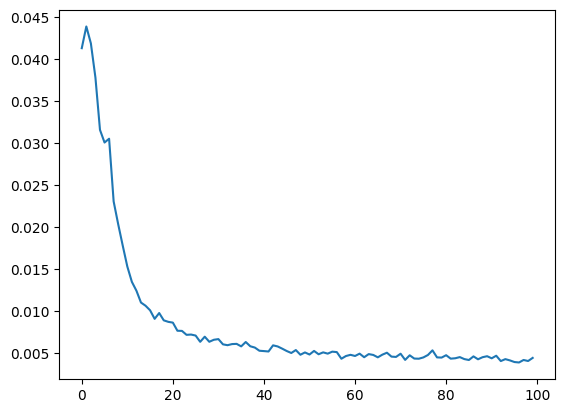

In [21]:
ls=plt.plot(np.array(loss_his)/(batch+1))


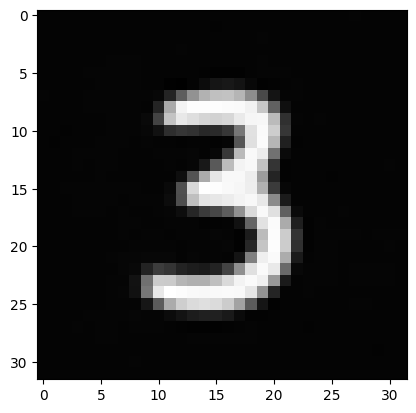

In [23]:
plt.imshow(atlas[0],cmap='gray')